In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display
from torch.utils import data

## 统计工具

## 训练

In [2]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, xlim, ylim):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.grid()

def plot(xs, ys, xlabel, ylabel, xlim=None, ylim=None, xscale='linear', yscale='linear', legend=None, figsize=(6, 3)):
    plt.rcParams['figure.figsize'] =figsize
    set_axes(plt.gca(), xlabel, ylabel, xscale, yscale, xlim, ylim)
    try:
        len(xs[0])
    except:
        xs = [xs]
    for x, y in zip(xs, ys):
        plt.plot(x, y)
    plt.legend(legend if legend else [])

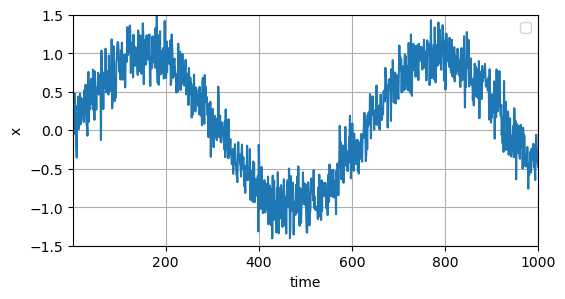

In [3]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time)+torch.normal(0, 0.2, (T,))
plot(time, [x], 'time', 'x', xlim=[1, 1000], ylim=[-1.5, 1.5])


In [4]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape(-1, 1)

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [6]:
batch_size, n_train = 16, 600
train_iter = load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [7]:
def get_net():
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    net = nn.Sequential(
        nn.Linear(4, 10), nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

In [8]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [9]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)     ## 损失的总和、样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

In [11]:
net = get_net()
loss = nn.MSELoss(reduction='none')
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.068565
epoch 2, loss: 0.061393
epoch 3, loss: 0.056148
epoch 4, loss: 0.055938
epoch 5, loss: 0.057565


## 预测

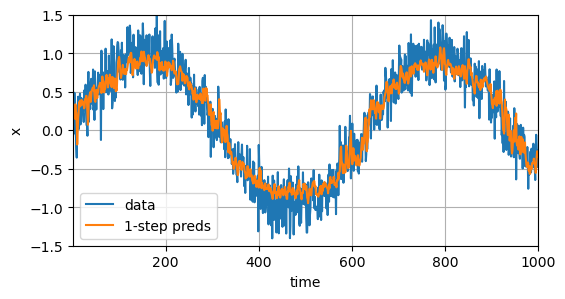

In [12]:
onestep_preds = net(features)
plot([time, time[tau:]], 
     [x.detach().numpy(), onestep_preds.detach().numpy()],
     'time', 'x', legend=['data', '1-step preds'], 
     xlim=[1, 1000], ylim=[-1.5, 1.5],
     figsize=(6, 3))

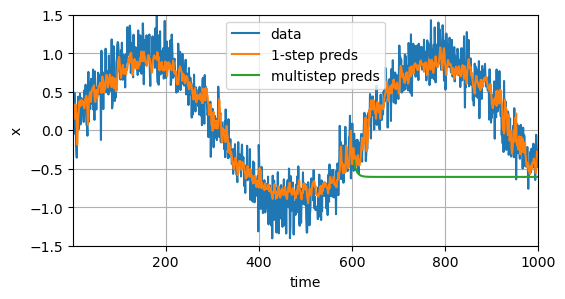

In [13]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape(1, -1))
plot([time, time[tau:], time[n_train+tau:]], 
     [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train+tau:].detach().numpy()],
     'time', 'x', legend=['data', '1-step preds', 'multistep preds'],
     xlim=[1,1000], ylim=[-1.5, 1.5],
     figsize=(6, 3))

In [14]:
"""example
x = torch.randn(10, 1)
print(x)
x[9] = torch.tensor([[1.]])
print(x)
"""
"""output
tensor([[ 0.9660],
        [ 1.3873],
        [ 3.2197],
        [-1.6714],
        [ 0.0352],
        [ 2.3001],
        [-0.5982],
        [-0.5802],
        [-0.0800],
        [-0.9672]])
tensor([[ 0.9660],
        [ 1.3873],
        [ 3.2197],
        [-1.6714],
        [ 0.0352],
        [ 2.3001],
        [-0.5982],
        [-0.5802],
        [-0.0800],
        [ 1.0000]])
"""


'output\ntensor([[ 0.9660],\n        [ 1.3873],\n        [ 3.2197],\n        [-1.6714],\n        [ 0.0352],\n        [ 2.3001],\n        [-0.5982],\n        [-0.5802],\n        [-0.0800],\n        [-0.9672]])\ntensor([[ 0.9660],\n        [ 1.3873],\n        [ 3.2197],\n        [-1.6714],\n        [ 0.0352],\n        [ 2.3001],\n        [-0.5982],\n        [-0.5802],\n        [-0.0800],\n        [ 1.0000]])\n'

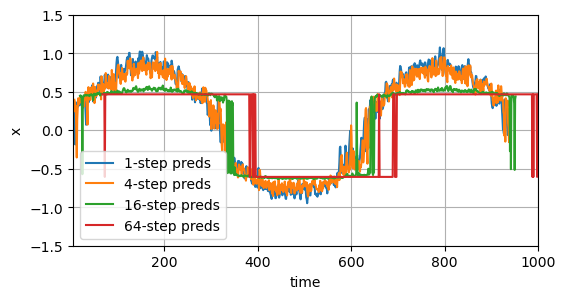

In [15]:
max_steps = 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))
for i in range(tau):
    features[:, i] = x[i:i+T-tau-max_steps+1]
for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1)
steps = (1, 4, 16, 64)
plot([time[tau+i-1:T-max_steps+i] for i in steps],
     [features[:, (tau+i-1)].detach().numpy() for i in steps],
     'time', 'x',
     legend = [f'{i}-step preds' for i in steps],
     xlim=[5, 1000], ylim=[-1.5, 1.5],
     figsize=(6, 3))

## Exercises

1. 改进本节实验中的模型
   - 是否包含了过去4个以上的观测结果？真实值需要是多少个？
   - 如果没有噪音，需要多少个过去的观测结果？提示：把$sin$和$cos$写成微分方程
   - 可以在保持特征总数不变的情况下合并旧的观察结果吗？这能提高正确度吗？为什么？
   - 改变神经网络架构并评估其性能

2. 一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题呢？

3. 时间是向前推进的因果模型在多大程度上适用于文本呢？

4. 举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型